In [2]:
# example of defining a u-net encoder-decoder generator model
from __future__ import print_function
import os
import random
from random import randint
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
plt.style.use("grayscale")
%matplotlib inline
#%matplotlib notebook
import time

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from skimage import color

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import mean_absolute_error,binary_crossentropy
import keras.backend as K

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

from keras.applications.vgg19 import VGG19
from keras.models import Model

from functions import *

In [26]:
def trainOnce(train_crops,iters,batch_size,weight_name,dir_name,loss_fact=0.5,loss_weights=[1,100],to_load=False):
    t_image_shape = (256,256,1);c_image_shape = (256,256,3)
    K.clear_session()
    
    d_model = define_discriminator(t_image_shape, c_image_shape)
    g_model = define_generator(t_image_shape)
    if to_load:
        g_model.load_weights(dir_name+'/g_model_' + weight_name_saved + '.h5')
        d_model.load_weights(dir_name+'/d_model_' + weight_name_saved + '.h5')
        
    gan_model = define_gan(g_model, d_model, t_image_shape, loss_fact=loss_fact, loss_weights=loss_weights)
    loss = train(d_model, g_model, gan_model, train_crops, iters, batch_size, weight_name=weight_name, dir_name=dir_name)
    save(loss, dir_name+'/loss__'+weight_name)

### Load Data

In [5]:
im_width = 640; im_height = 512
border = 5
# path_train = '../../../data/FLIR/training/Calib_cut/'
path_train = '/home/nvs/Documents/DB/FLIR/Calib/Sample2/'
#path_train = '/home/nadav.shalev/Desktop/Calib/'
X,Y = get_data(path_train, im_height, im_width)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0/1040,random_state=2019)

/home/nvs/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


### Prepare Model

In [29]:
batch_size = 2
dir_name = 'fry29.11'
weight_name = 'name1'
data_gen_args = dict(horizontal_flip=True)
train_crops = create_augment(X_train, 
               y_train, 
               dict_augments=data_gen_args, 
               batch_size=batch_size, 
               shuffle=True, 
               rand_crop=True, 
               seed=1234)
plot_crops = create_augment(X_train, 
               y_train, 
               dict_augments=data_gen_args, 
               batch_size=1, 
               shuffle=False, 
               rand_crop=False)
t_image_shape = (256,256,1);c_image_shape = (256,256,3)
d_model = define_discriminator(t_image_shape, c_image_shape)
g_model = define_generator(t_image_shape)
gan_model = define_gan(g_model, d_model, t_image_shape)


### load model

In [30]:
g_model.load_weights(dir_name+'/g_model_' + weight_name + '.h5')
d_model.load_weights(dir_name+'/d_model_' + weight_name + '.h5')

### plot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


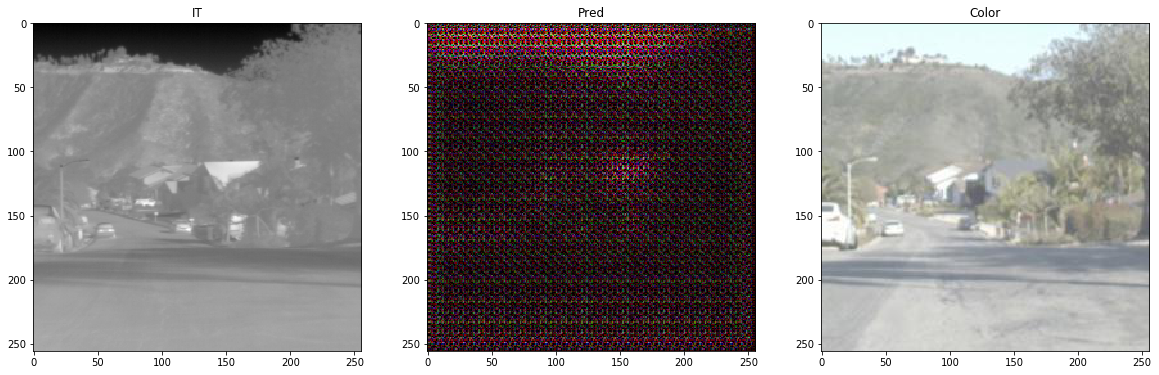

In [31]:
xi = plot_sample(plot_crops, g_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


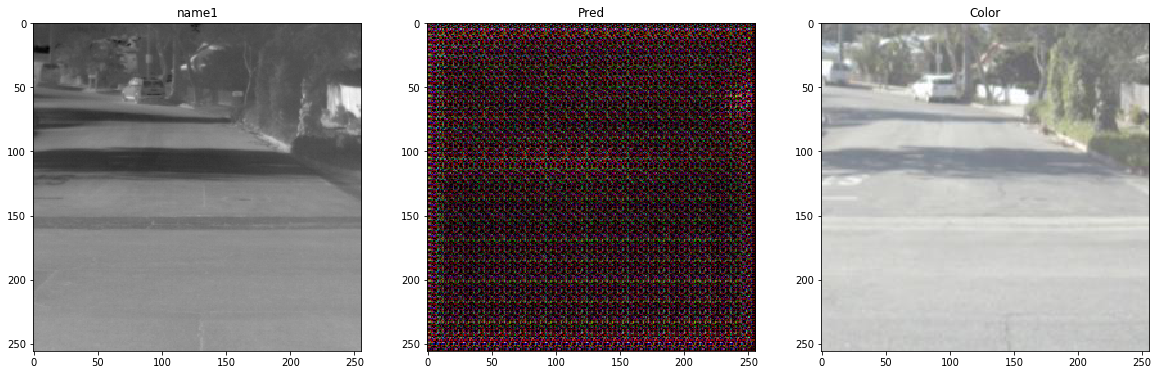

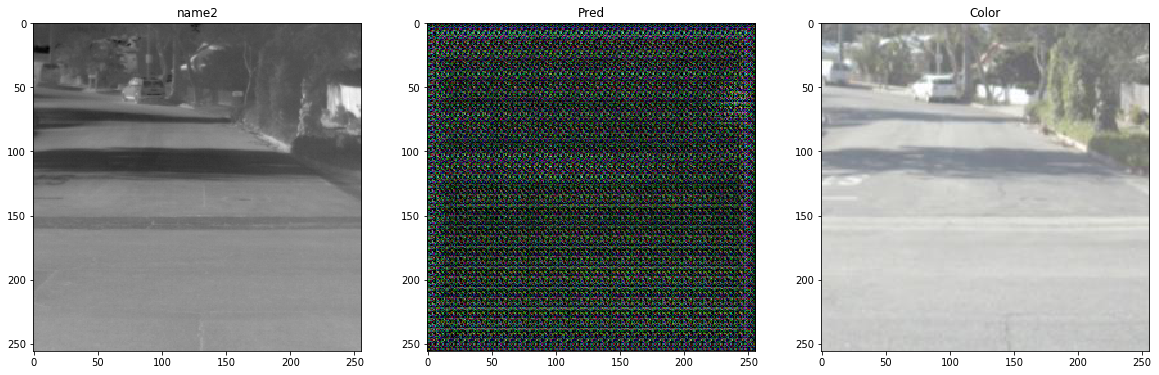

In [32]:
# dir_name = 'train26.11'
g_names = ['name1','name2']
plot_compare(g_names, dir_name, g_model, plot_crops)

### loss

0.2235756665468216


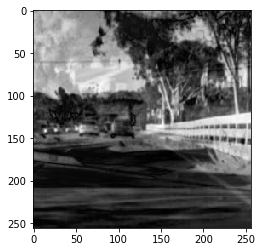

In [15]:
x, y = next(plot_crops)
xK = K.constant(x)
yK= K.constant(y)
x2, y2 = next(plot_crops)
xK2 = K.constant(x2)
yK2 = K.constant(y2)

# predict
yR = K.constant(g_model.predict(x))

ssimTF = ssim_tf(ssim_fact=1)
vggloss = vgg_obj(vgg_fact=1)

# loss = ssimTF(yR,yK)
# loss = vggloss(yR,yK)
loss = mean_absolute_error(yK2,yK)
# loss = binary_crossentropy(yR,yK)
loss = K.eval(loss).squeeze()

loss_once = np.sum(np.sum(loss, axis=-1), axis=-1)/loss.size
print(loss_once)
pltLoss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
plt.imshow(pltLoss)

# Train

In [28]:
scedual_trainings(batch_size, dir_name)

0, d_real[0.388] d_fake[0.643] g_total[49.348] g_cross[1.603] g_loss[0.477] 12.659[sec]
best loss model saved!
model saved...
1, d_real[0.868] d_fake[0.691] g_total[56.035] g_cross[1.625] g_loss[0.544] 4.489[sec]
2, d_real[0.653] d_fake[0.482] g_total[58.673] g_cross[1.822] g_loss[0.569] 4.609[sec]
3, d_real[0.429] d_fake[0.315] g_total[51.541] g_cross[1.840] g_loss[0.497] 5.858[sec]
4, d_real[0.460] d_fake[0.321] g_total[41.883] g_cross[1.666] g_loss[0.402] 5.799[sec]
5, d_real[0.222] d_fake[0.234] g_total[50.015] g_cross[2.028] g_loss[0.480] 5.802[sec]
6, d_real[0.125] d_fake[0.356] g_total[45.359] g_cross[2.510] g_loss[0.428] 5.779[sec]
7, d_real[0.166] d_fake[0.366] g_total[53.452] g_cross[2.774] g_loss[0.507] 5.785[sec]
8, d_real[0.152] d_fake[0.548] g_total[50.448] g_cross[2.354] g_loss[0.481] 5.923[sec]
9, d_real[0.065] d_fake[0.426] g_total[46.824] g_cross[2.734] g_loss[0.441] 6.225[sec]
0, d_real[0.541] d_fake[0.728] g_total[56.117] g_cross[2.741] g_loss[0.534] 11.075[sec]
bes

In [16]:
trainOnce(train_crops,
              iters=10,
              batch_size=batch_size,
              weight_name=weight_name,
              dir_name=dir_name,
              loss_fact=0.5,
              loss_weights=[1,100],
              to_load=False)

Instructions for updating:
Use tf.cast instead.


/home/nvs/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0, d_real[0.257] d_fake[0.984] g_total[43.426] g_cross[0.749] g_loss[0.427] 13.259[sec]
best loss model saved!
model saved...
1, d_real[1.043] d_fake[0.753] g_total[52.856] g_cross[1.271] g_loss[0.516] 4.520[sec]
2, d_real[0.359] d_fake[0.631] g_total[58.655] g_cross[1.811] g_loss[0.568] 4.715[sec]
3, d_real[0.585] d_fake[0.438] g_total[49.304] g_cross[1.521] g_loss[0.478] 6.065[sec]
4, d_real[0.476] d_fake[0.319] g_total[41.605] g_cross[1.543] g_loss[0.401] 6.116[sec]
5, d_real[0.297] d_fake[0.314] g_total[47.784] g_cross[2.178] g_loss[0.456] 6.064[sec]
6, d_real[0.274] d_fake[0.581] g_total[43.106] g_cross[2.272] g_loss[0.408] 6.000[sec]
7, d_real[0.293] d_fake[0.449] g_total[48.781] g_cross[2.211] g_loss[0.466] 6.176[sec]
8, d_real[0.264] d_fake[0.439] g_total[46.996] g_cross[2.026] g_loss[0.450] 5.922[sec]
9, d_real[0.171] d_fake[0.428] g_total[45.074] g_cross[2.260] g_loss[0.428] 5.842[sec]
